# Proyek Klasifikasi Gambar: klasifikasi 7 kategori pokemon
- **Nama:** kevin caesar
- **Email:** kevin.caesar.2020@ftmm.unair.ac.id
- **ID Dicoding:** kevin_caesar_LVy6


link dataset : https://www.kaggle.com/datasets/ltihium123/pokemon-dataset

keterangan:

dataset terdiri dari 11 kategori namun yang digunakan hanya 7 kelas yaitu yang datanya cukup imbalanced 4 kategori yang tidak digunakan karena memiliki imbalanced yang eksterim.


* Mengimplementasikan Callback

**DONE MENGIMPLEMENTASIKAN Callback**
* Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.

**Done memiliki resolusi berbeda-beda dapat dilihat di data preprocessing  yaitu ukurannya 245 x 342 **
* Dataset yang digunakan berisi lebih dari 10000 gambar.

**DONE Data asli dan tidak augmentasi terdapat 11134 gambar dapat dilihat di tahap data preprocessing**
* Akurasi pada training set dan validation set minimal 95%.

**DONE  accuracy: 0.9609, val_accuracy: 0.9688**
* Memiliki 3 buah kelas atau lebih.

**DONE MEMILIKI 7 Kelas dari 11 kelas yang digunakan**
* Melakukan inference menggunakan salah satu model (TF-Lite, TFJS atau savedmodel dengan tf serving).

**Done menggunakan saved model dan tensorflow lite**

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
# disediakan google colab untuk kebutuhan upload file json akun
from google.colab import files
files.upload()

In [3]:
# Download kaggle dataset and unzip the file
!kaggle datasets download -d ltihium123/pokemon-dataset
!unzip pokemon-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Pokemon/Lightning/53.jpg  
  inflating: Pokemon/Lightning/530.jpg  
  inflating: Pokemon/Lightning/531.jpg  
  inflating: Pokemon/Lightning/532.jpg  
  inflating: Pokemon/Lightning/533.jpg  
  inflating: Pokemon/Lightning/534.jpg  
  inflating: Pokemon/Lightning/535.jpg  
  inflating: Pokemon/Lightning/536.jpg  
  inflating: Pokemon/Lightning/537.jpg  
  inflating: Pokemon/Lightning/538.jpg  
  inflating: Pokemon/Lightning/539.jpg  
  inflating: Pokemon/Lightning/54.jpg  
  inflating: Pokemon/Lightning/540.jpg  
  inflating: Pokemon/Lightning/541.jpg  
  inflating: Pokemon/Lightning/542.jpg  
  inflating: Pokemon/Lightning/543.jpg  
  inflating: Pokemon/Lightning/544.jpg  
  inflating: Pokemon/Lightning/545.jpg  
  inflating: Pokemon/Lightning/546.jpg  
  inflating: Pokemon/Lightning/547.jpg  
  inflating: Pokemon/Lightning/548.jpg  
  inflating: Pokemon/Lightning/549.jpg  
  inflating: Pokemon/Lightning/55.jpg  
  inflati

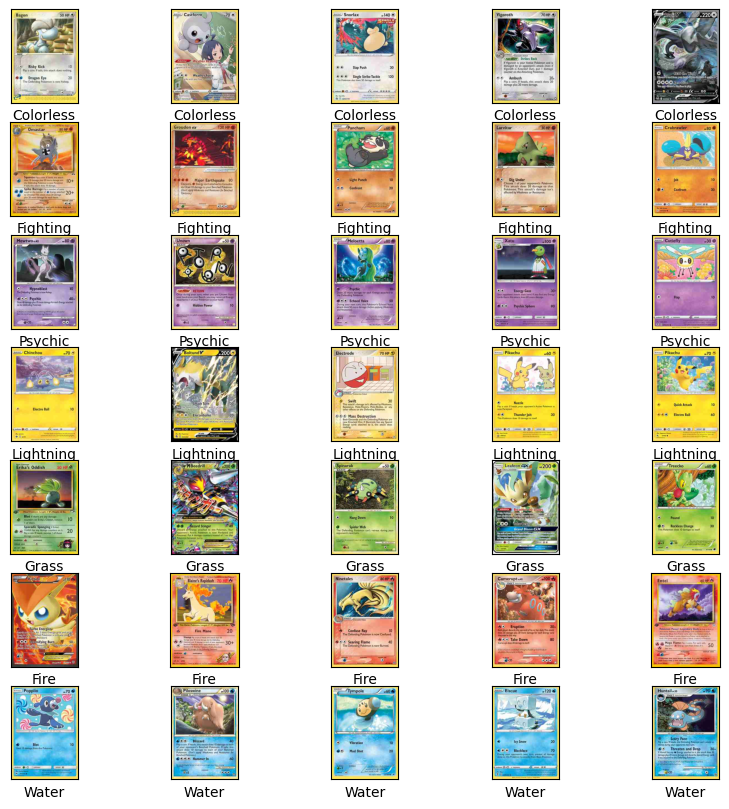

In [ ]:
#menyatukan ke dalam satu folder
import os
import shutil

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
pokemon_image = {}

# Tentukan path sumber train
path = "Pokemon/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    pokemon_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 7 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "/content/Pokemon/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(pokemon_image.keys()), 5, figsize=(10, 10))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(pokemon_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])



intepretasi:

dari hasil diatas ditampilkan bahwa ditiap kategori memiliki reoslusi gambar yang berbeda-beda

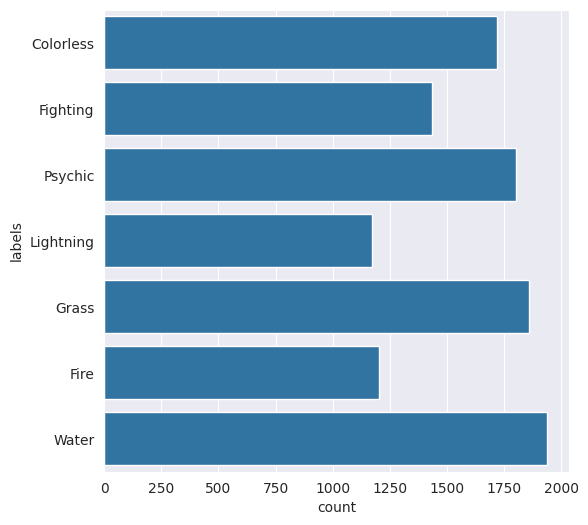

In [ ]:
# Define source path
animal_path = "Pokemon/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(animal_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

In [ ]:
# Path ke direktori dataset
dataset_dir = '/content/Pokemon/dataset'

# Daftar untuk menyimpan data
data = []

# Iterasi melalui setiap folder (colorless,fairy,fighting,fire,grass,lightning,pyshic)
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)

    if os.path.isdir(label_dir):
        # Iterasi melalui setiap gambar dalam folder
        for filename in os.listdir(label_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Ganti ekstensi jika perlu
                filepath = os.path.join(label_dir, filename)
                data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Membuat DataFrame
dataset_df = pd.DataFrame(data)

In [ ]:
# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (None, None)

In [ ]:
# Menambahkan kolom resolusi ke dataset_df
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)

In [ ]:
#menampilkan resolusi dataset dalam dataframe
dataset_df

,filename,filepath,label,resolution
0,1074.jpg,/content/Pokemon/dataset/Colorless/1074.jpg,Colorless,"(245, 342)"
1,1575.jpg,/content/Pokemon/dataset/Colorless/1575.jpg,Colorless,"(245, 342)"
2,1036.jpg,/content/Pokemon/dataset/Colorless/1036.jpg,Colorless,"(245, 342)"
3,1085.jpg,/content/Pokemon/dataset/Colorless/1085.jpg,Colorless,"(245, 342)"
4,915.jpg,/content/Pokemon/dataset/Colorless/915.jpg,Colorless,"(245, 342)"
...,...,...,...,...
11129,525.jpg,/content/Pokemon/dataset/Water/525.jpg,Water,"(245, 342)"
11130,1263.jpg,/content/Pokemon/dataset/Water/1263.jpg,Water,"(240, 330)"
11131,791.jpg,/content/Pokemon/dataset/Water/791.jpg,Water,"(245, 342)"
11132,873.jpg,/content/Pokemon/dataset/Water/873.jpg,Water,"(245, 342)"


In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Pokemon/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Colorless,1721
Fighting,1437
Fire,1202
Grass,1861
Lightning,1171
Psychic,1803
Water,1939


## Modelling

0### A. Modelling **pertama**

In [4]:
#menggunakan callback jika data akurasi sudah 95%
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True


In [5]:
def animal():

    TRAINING_DIR = "/content/Pokemon/dataset"
    training_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode ='nearest',
        rotation_range=40,
        validation_split=0.2) # Dataset dibagi menjadi 80% train 20% validasi

    train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(100,100),
        class_mode='categorical',
        shuffle= True,
        subset='training')

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator= training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(100,100),
        class_mode='categorical',
        shuffle = True,
        subset='validation')

    model = tf.keras.models.Sequential([
        #layer1
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        #layer2
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #layer3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #layer4
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #Flatten
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        #Dense layer1
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        #Dense layer2
        tf.keras.layers.Dense(32, activation='relu'),
        #output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    callback = callback_model()
#optimizer='RMSprop',
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        epochs=4500,
        steps_per_epoch=20,
        validation_data=validation_generator,
        callbacks=callback,
        verbose=1,
        validation_steps=3)
    return model, history

In [6]:
model, history = animal()

Found 8910 images belonging to 7 classes.
Found 2224 images belonging to 7 classes.
Epoch 1/4500
20/20 [==============================] - 5s 183ms/step - loss: 1.9533 - accuracy: 0.1641 - val_loss: 1.9000 - val_accuracy: 0.2083
Epoch 2/4500
20/20 [==============================] - 3s 167ms/step - loss: 1.7985 - accuracy: 0.2234 - val_loss: 1.7424 - val_accuracy: 0.2708
Epoch 3/4500
20/20 [==============================] - 3s 167ms/step - loss: 1.6973 - accuracy: 0.2906 - val_loss: 1.6879 - val_accuracy: 0.3125
Epoch 4/4500
20/20 [==============================] - 3s 166ms/step - loss: 1.7360 - accuracy: 0.2859 - val_loss: 1.5875 - val_accuracy: 0.3021
Epoch 5/4500
20/20 [==============================] - 3s 168ms/step - loss: 1.5794 - accuracy: 0.3521 - val_loss: 1.6376 - val_accuracy: 0.2292
Epoch 6/4500
20/20 [==============================] - 3s 169ms/step - loss: 1.4674 - accuracy: 0.3547 - val_loss: 1.5960 - val_accuracy: 0.3438
Epoch 7/4500
20/20 [==============================] 

## Evaluasi dan Visualisasi

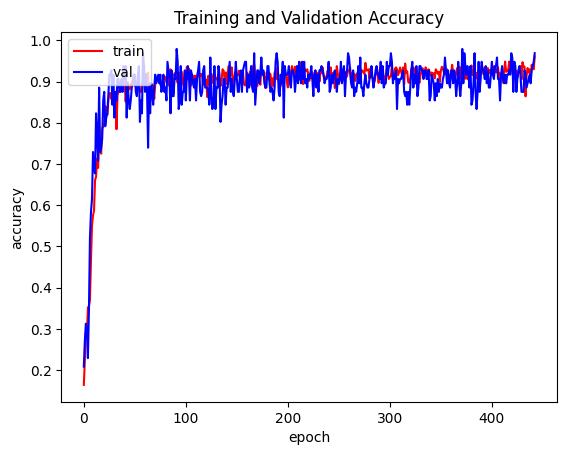

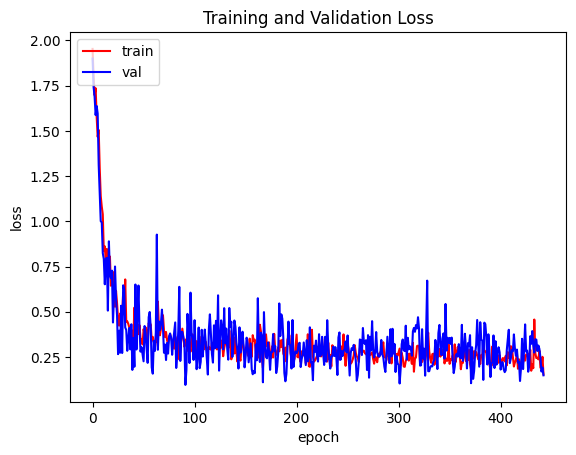

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

### Saved model

In [8]:
model.save('/content/saved_model')

In [9]:
# Compress the folder
from google.colab import files
shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

# Download the compressed file
files.download('/content/saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tensorflow.js

In [23]:
!pip install tensorflowjs

In [12]:
# Convert the model to TensorFlow.js format
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/model

2024-09-05 05:43:41.798578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 05:43:41.817897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 05:43:41.823690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 05:43:42.996570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1725515025.480500  139858 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0


In [13]:
#menyatukan ke dalam satu folder
import os
import shutil
# Compress the folder
shutil.make_archive('/content/model', 'zip', '/content/model')

# Download the compressed file
files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tensorflow lite

In [14]:
# Load the TensorFlow SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Save the converted model to a file
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [15]:
class_labels = ["Colorless", "Fighting", "Fire","Grass","Lightning","Psychic","Water"]

with open('/content/label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")


## Inference

In [ ]:
from google.colab import files
import io

Saving 10 (1).jpg to 10 (1).jpg


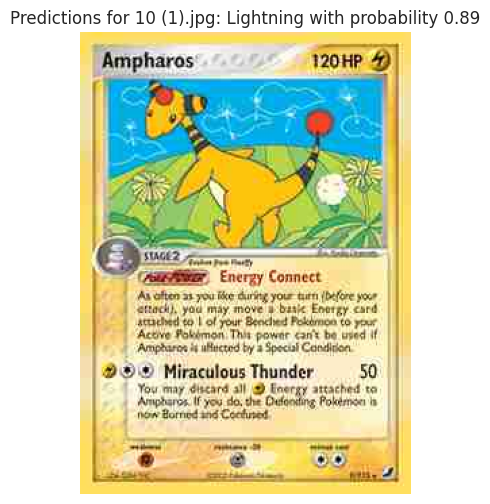

In [ ]:
# Upload the new image data
uploaded = files.upload()

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess image
def preprocess_image(image, target_size):
    image = image.resize(target_size)
    image = np.array(image).astype('float32')  # Convert to float32
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Read the class labels
with open('/content/label.txt', 'r') as f:
    class_labels = f.read().splitlines()

# Model's input size is (150, 150)
target_size = (100, 100)

# Make predictions
for filename in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[filename]))
    preprocessed_image = preprocess_image(image, target_size)

    # Set the tensor to point to the input data
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    # Run the interpreter
    interpreter.invoke()

    # Get the predictions
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predictions for {filename}: {predicted_class_label} with probability {predictions[0][predicted_class_index]:.2f}")
    plt.axis('off')
    plt.show()

Saving 100.jpg to 100.jpg


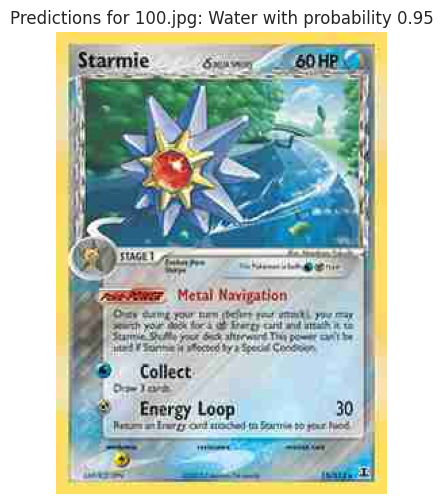

In [ ]:
# Upload the new image data
uploaded = files.upload()

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess image
def preprocess_image(image, target_size):
    image = image.resize(target_size)
    image = np.array(image).astype('float32')  # Convert to float32
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Read the class labels
with open('/content/label.txt', 'r') as f:
    class_labels = f.read().splitlines()

# Model's input size is (150, 150)
target_size = (100, 100)

# Make predictions
for filename in uploaded.keys():
    image = Image.open(io.BytesIO(uploaded[filename]))
    preprocessed_image = preprocess_image(image, target_size)

    # Set the tensor to point to the input data
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    # Run the interpreter
    interpreter.invoke()

    # Get the predictions
    predictions = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predictions for {filename}: {predicted_class_label} with probability {predictions[0][predicted_class_index]:.2f}")
    plt.axis('off')
    plt.show()

## Requirement

In [17]:
!pip install pipreqs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pipreqs "/content/drive/MyDrive/Colab Notebooks/submission_terakhir" --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/submission_terakhir/requirements.txt
